# Statistical Analysis of the seeds dataset

This notebook contains the code and results of the anaysis done on the seeds dataset. Bootstrapping is a wonderful approach to test if the sample statistics are representative of the true popoulation statistics. A comparison of Pearson correlation coefficients determines which features are highly correlated, and in essence can then be left out of the final model to reduce redundancy and increase performance.  

In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pymc3 as pm
import scipy.stats as st
import statsmodels as sm
%matplotlib inline


In [4]:
#Load the data into a data frame and separate into X and y.
seeds = pd.read_csv('seeds.csv')
seeds.head()

,area,perimeter,compactness,length,width,asymmetry_coefficient,groove_length,class
0,15.26,14.84,0.8710,5.763,3.312,2.221,5.220,1.0
1,14.88,14.57,0.8811,5.554,3.333,1.018,4.956,1.0
2,14.29,14.09,0.9050,5.291,3.337,2.699,4.825,1.0
3,13.84,13.94,0.8955,5.324,3.379,2.259,4.805,1.0
4,16.14,14.99,0.9034,5.658,3.562,1.355,5.175,1.0


In [5]:
# Show the summary statistics
seeds.describe()

,area,perimeter,compactness,length,width,asymmetry_coefficient,groove_length,class
count,210.000000,210.000000,210.000000,210.000000,210.000000,210.000000,210.000000,210.000000
mean,14.847524,14.559286,0.870999,5.628533,3.258605,3.700201,5.408071,2.000000
std,2.909699,1.305959,0.023629,0.443063,0.377714,1.503557,0.491480,0.818448
min,10.590000,12.410000,0.808100,4.899000,2.630000,0.765100,4.519000,1.000000
25%,12.270000,13.450000,0.856900,5.262250,2.944000,2.561500,5.045000,1.000000
50%,14.355000,14.320000,0.873450,5.523500,3.237000,3.599000,5.223000,2.000000
75%,17.305000,15.715000,0.887775,5.979750,3.561750,4.768750,5.877000,3.000000
max,21.180000,17.250000,0.918300,6.675000,4.033000,8.456000,6.550000,3.000000


In [3]:
#Separate the classes for sampling:
seeds1 = seeds[seeds["class"]==1]
seeds2 = seeds[seeds["class"]==2]
seeds3 = seeds[seeds["class"]==3]
seeds2.tail()

,area,perimeter,compactness,length,width,asymmetry_coefficient,groove_length,class
135,15.38,14.66,0.8990,5.477,3.465,3.600,5.439,2.0
136,17.36,15.76,0.8785,6.145,3.574,3.526,5.971,2.0
137,15.57,15.15,0.8527,5.920,3.231,2.640,5.879,2.0
138,15.60,15.11,0.8580,5.832,3.286,2.725,5.752,2.0
139,16.23,15.18,0.8850,5.872,3.472,3.769,5.922,2.0


## Bootstrapping

In this section we randomly sample the data for each class, creating 10,000 samples of the training data, all of equal size. We compare the results using histograms, then find the confidence interval for the simulated sample, and finally, calculate the percentile score for each observed difference between feature classes. This value will help us determine if the geometric properties used to distinguish the seed species are truly likely to be different in scope on the scale of the full population, or if the observed difference could be a product of chance due to the tiny sample size. 

### Null Hypothesis

The null hypothesis is that each class has the same mean for each feature (meaning they are not likely distinguishable by geometric properties on the scale of the whole population).

### Alternative Hypothesis

The alternative hypothesis is that each class has a different mean for each feature (meaning they are likely distinguishable by geometric properties on the scale of the whole population).

In [4]:
# Create a list to hold dataframes and choose number of iterations:
master_DF_lst = []
iters = 10000

# Take the difference of means for each feature between each class and create a dataframe to hold them:
mean_obs_diff12 = abs(seeds1.mean() - seeds2.mean())
mean_obs_diff13 = abs(seeds1.mean() - seeds3.mean())
mean_obs_diff23 = abs(seeds2.mean() - seeds3.mean())
std_obs_diff12 = abs(seeds1.std() - seeds2.std())
std_obs_diff13 = abs(seeds1.std() - seeds3.std())
std_obs_diff23 = abs(seeds2.std() - seeds3.std())
obsDF =pd.DataFrame([mean_obs_diff12, mean_obs_diff13, mean_obs_diff23, std_obs_diff12, std_obs_diff13, std_obs_diff23])

# Shift the mean of each feature to zero, then add the observed difference to put each 
# class with equal means for bootstrapping comparison:
seeds12_shifted = pd.DataFrame(seeds1 - seeds1.mean() + mean_obs_diff12)
seeds13_shifted = pd.DataFrame(seeds1 - seeds1.mean() + mean_obs_diff13)
seeds21_shifted = pd.DataFrame(seeds2 - seeds2.mean() + mean_obs_diff12)
seeds23_shifted = pd.DataFrame(seeds2 - seeds2.mean() + mean_obs_diff23)
seeds31_shifted = pd.DataFrame(seeds3 - seeds3.mean() + mean_obs_diff13)
seeds32_shifted = pd.DataFrame(seeds3 - seeds3.mean() + mean_obs_diff23)

#Sample the shifted dataframes, taking the difference between feature means and standard deviations.
# Store the results in the master list:
for i in range(len(seeds.columns)-1):
        cols = (seeds.columns[i])
        
        diffDF = pd.DataFrame({'mean_diff12': [seeds12_shifted.iloc[:,i].sample(len(seeds1),replace=True).mean()-
                                                        seeds21_shifted.iloc[:,i].sample(len(seeds1),replace=True).mean()
                                                        for num in range(iters)], 
                                    'mean_diff13' : [seeds13_shifted.iloc[:,i].sample(len(seeds1),replace=True).mean()-
                                                             seeds31_shifted.iloc[:,i].sample(len(seeds1),replace=True).mean()
                                                             for b in range(iters)],
                                    'mean_diff23' : [seeds23_shifted.iloc[:,i].sample(len(seeds1),replace=True).mean()-
                                                             seeds32_shifted.iloc[:,i].sample(len(seeds1),replace=True).mean()
                                                             for c in range(iters)],
                                    'std_diff12' : [seeds12_shifted.iloc[:,i].sample(len(seeds1),replace=True).std()-
                                                            seeds21_shifted.iloc[:,i].sample(len(seeds1),replace=True).std()
                                                            for d in range(iters)], 
                                    'std_diff13' : [seeds13_shifted.iloc[:,i].sample(len(seeds1),replace=True).std()-
                                                            seeds31_shifted.iloc[:,i].sample(len(seeds1),replace=True).std()
                                                            for e in range(iters)],
                                    'std_diff23' : [seeds23_shifted.iloc[:,i].sample(len(seeds1),replace=True).std()-
                                                            seeds32_shifted.iloc[:,i].sample(len(seeds1),replace=True).std()
                                                            for f in range(iters)]})
        master_DF_lst.append((cols,diffDF))

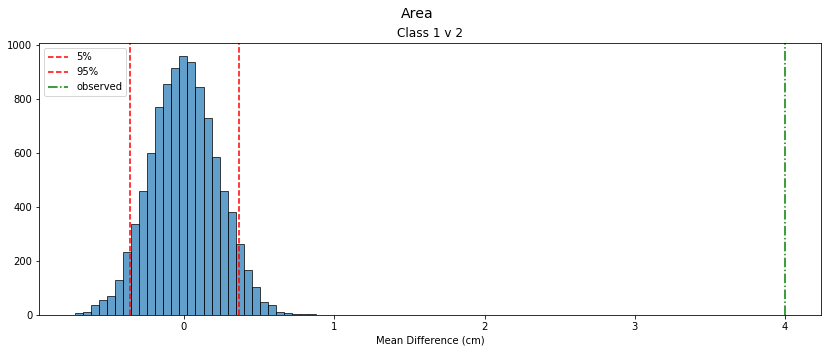

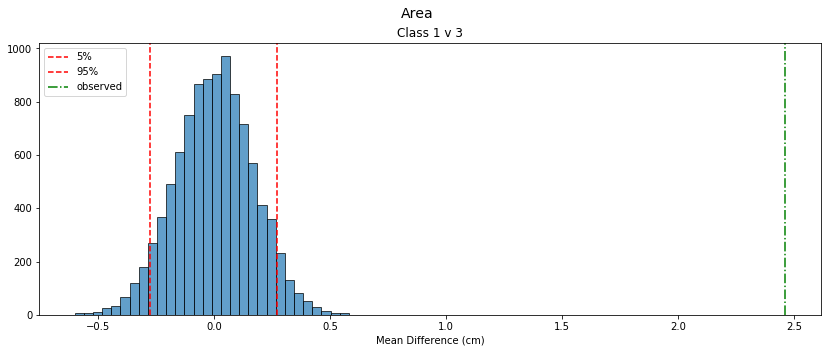

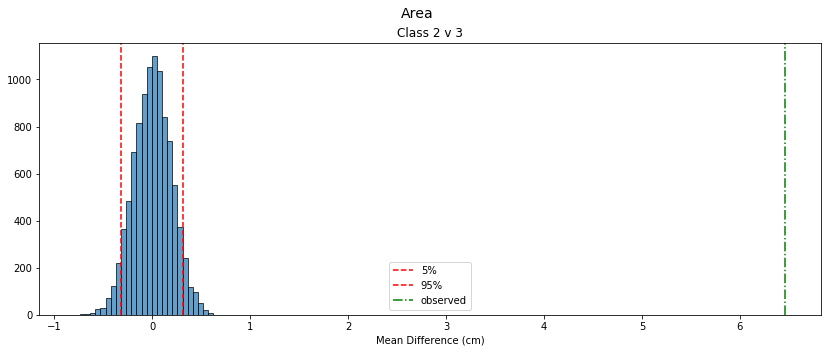

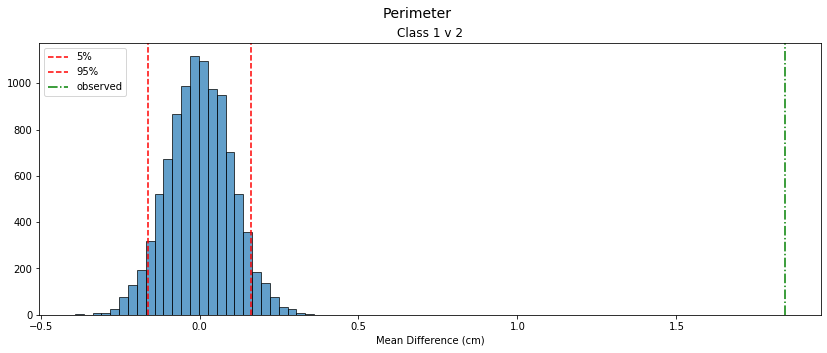

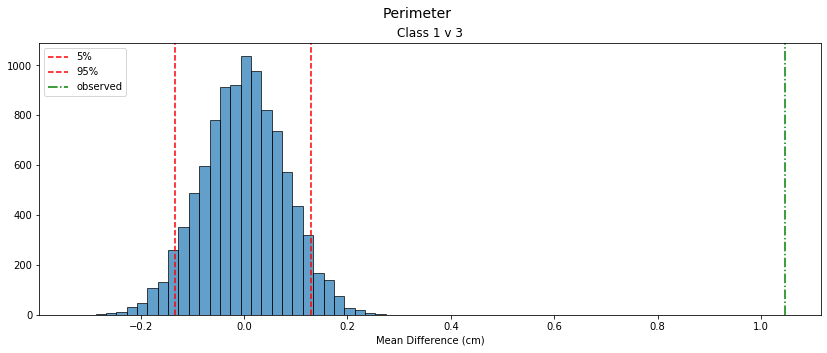

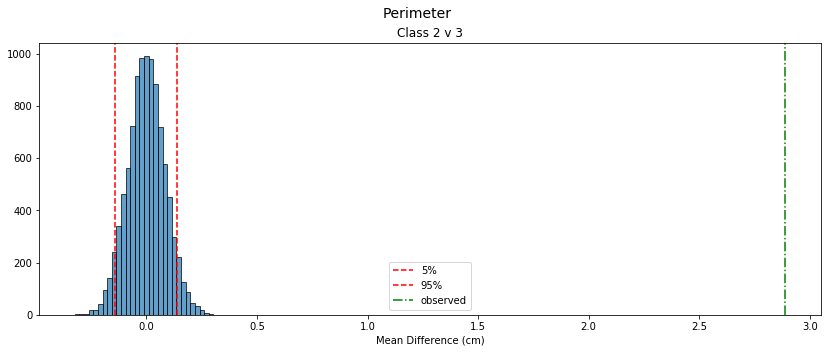

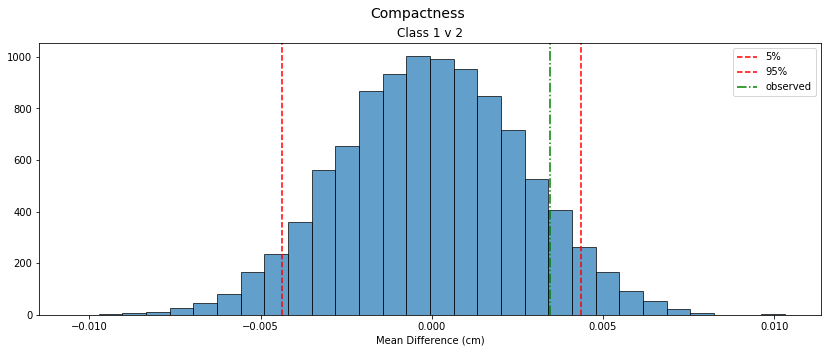

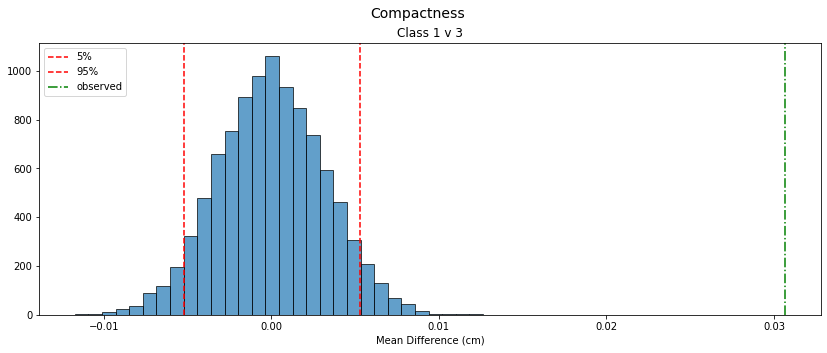

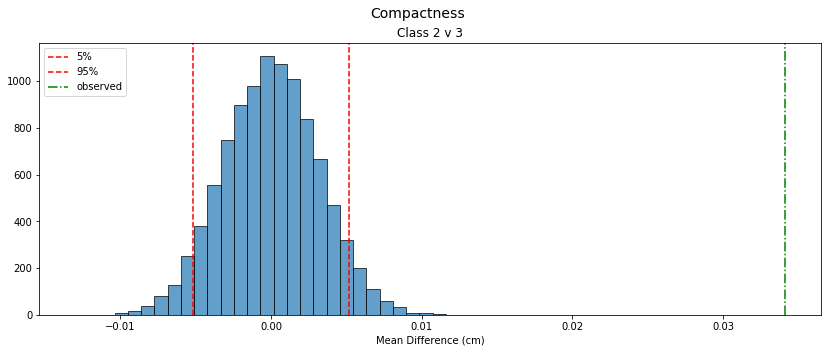

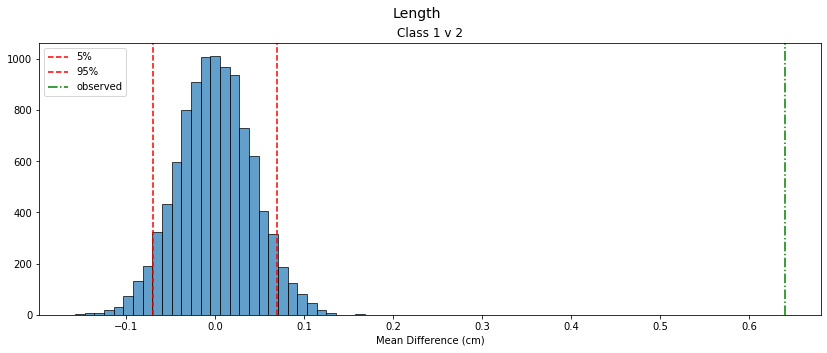

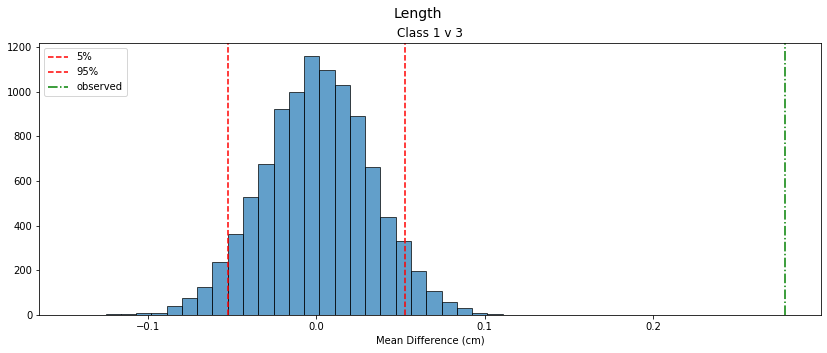

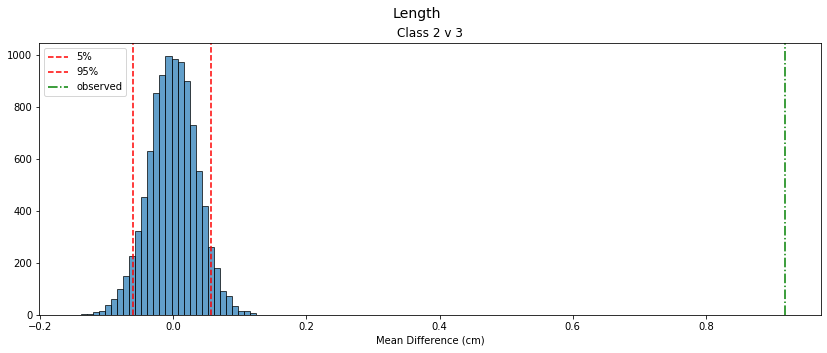

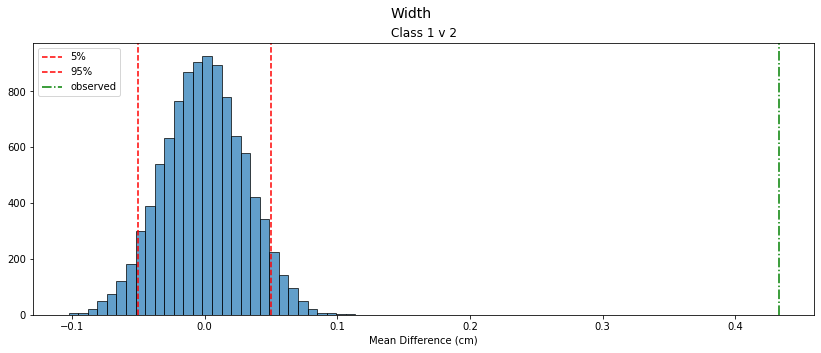

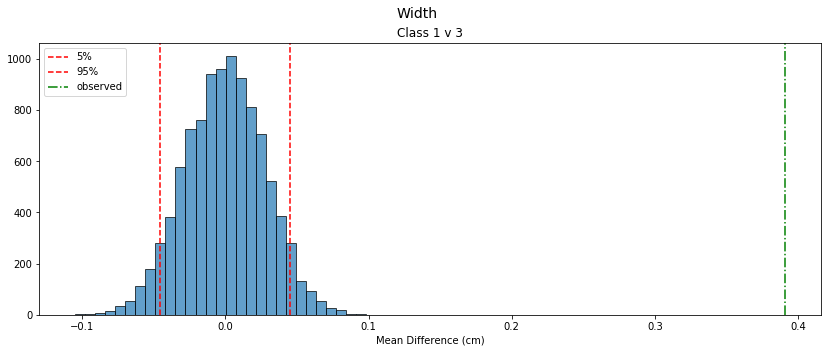

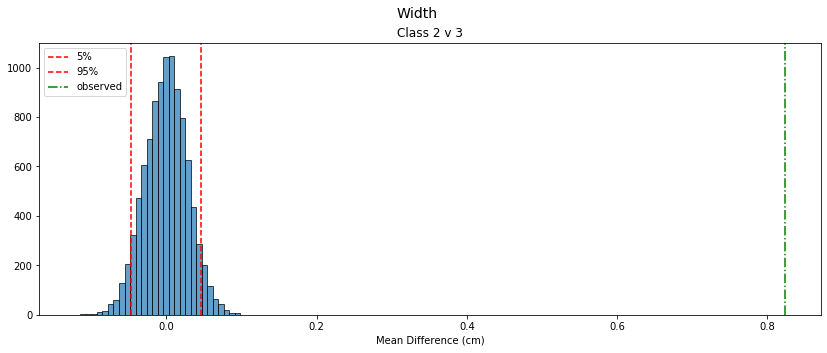

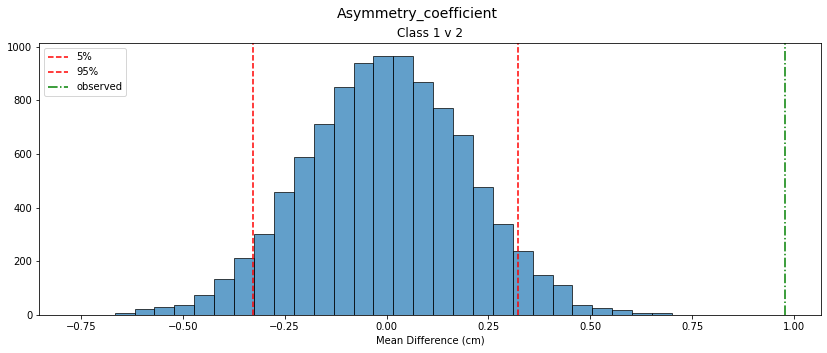

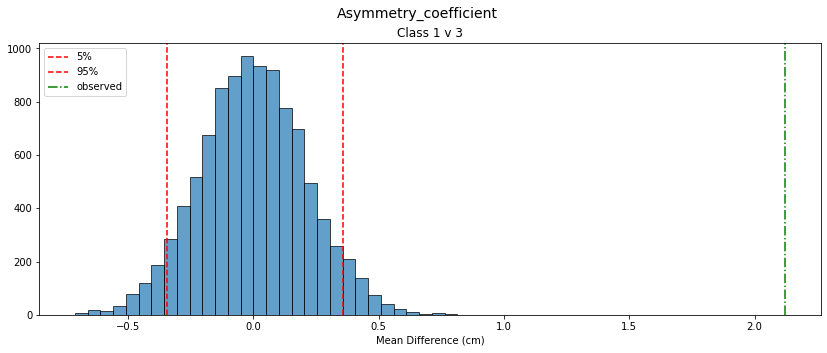

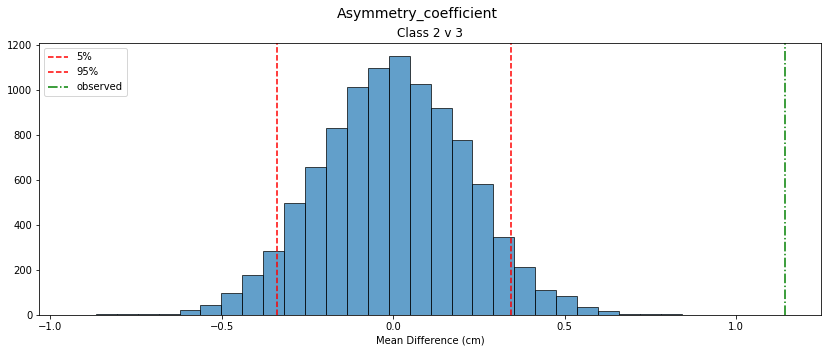

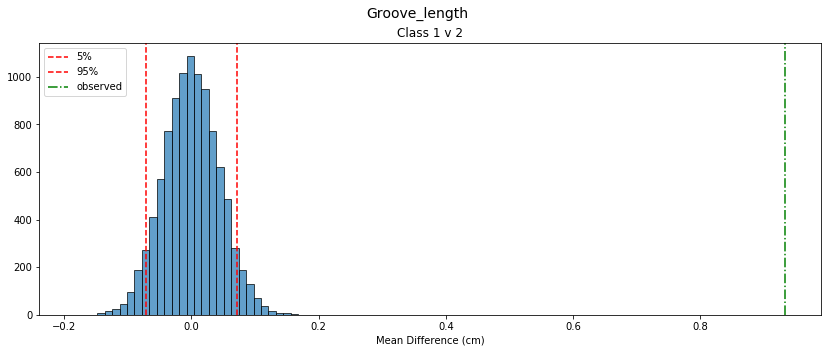

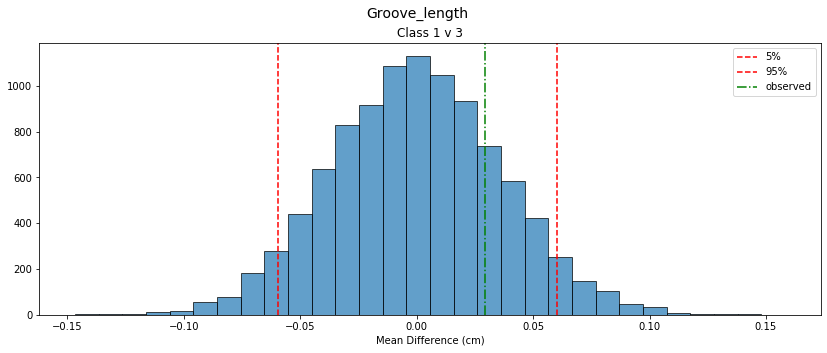

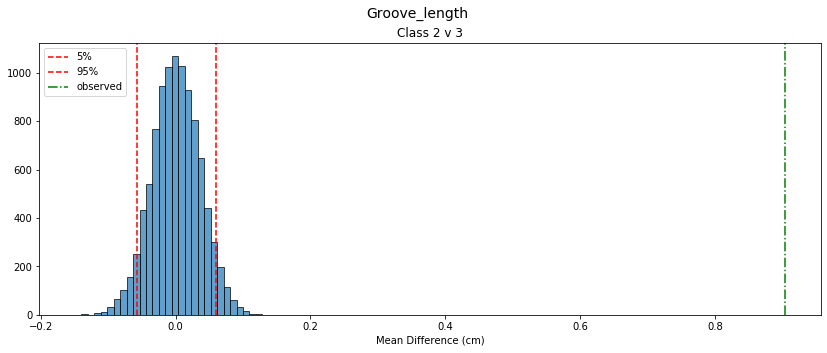

In [5]:
# Initialize index and create list to store percentile results:
idx1 = 0
percentile_list = []

# Loop through the master list, tracking column names and finding the .95 CI for that particular comparison:
for lst in master_DF_lst:
    idx2 = 0
    comparison = lst[0]
    df = lst[1]
    quantiles = df.quantile([.05, .95])
    
    # For each feature in the sampled dataframe, find the percentile of the observed difference. 
    # Define the upper and lower quantile bounds for graphing.
    for col in df.columns:
        if col == 'std_diff12':
            break
        percentile = st.percentileofscore(df[col], score=obsDF.iloc[idx2,idx1])
        percentile_list.append((comparison,percentile))
        quants = quantiles[col].values
        upper = quants[1]
        lower = quants[0]
        # Plot histograms for the comparison of each class:
        _=plt.figure()
        _=plt.suptitle(str(comparison.capitalize()), fontsize=14)
        _=plt.title('Class '+str(col[-2])+' v '+str(col[-1]))
        _=df[col].hist(bins=30, figsize=(14,5), edgecolor='k', grid=False, alpha=.7)
        _=plt.axvline(upper, color='r', linestyle='--')
        _=plt.axvline(lower, color='r', linestyle='--')
        _=plt.axvline(obsDF.iloc[idx2,idx1], color='g', linestyle='-.')
        _=plt.legend(['5%','95%','observed'])
        _=plt.xlabel('Mean Difference (cm)')
        plt.show()
        idx2 += 1
    idx1+=1


In [6]:
percentile_list

[('area', 100.0),
 ('area', 100.0),
 ('area', 100.0),
 ('perimeter', 100.0),
 ('perimeter', 100.0),
 ('perimeter', 100.0),
 ('compactness', 90.16),
 ('compactness', 100.0),
 ('compactness', 100.0),
 ('length', 100.0),
 ('length', 100.0),
 ('length', 100.0),
 ('width', 100.0),
 ('width', 100.0),
 ('width', 100.0),
 ('asymmetry_coefficient', 100.0),
 ('asymmetry_coefficient', 100.0),
 ('asymmetry_coefficient', 100.0),
 ('groove_length', 100.0),
 ('groove_length', 79.21),
 ('groove_length', 100.0)]

The bootstrapped histograms above clearly show that most of the observed differences in seed class are significant, and not just a matter of chance. Though the number of data points for each class is small, the seeds seem to be distinct enough from one another to distinguish them by comparing features most of the time. 

The minimum percentile score above is the observed difference in mean groove length between classes 1 and 3, which was about 79%. The only other score that was not maximum is the difference in mean compactness between classes 1 and 2, which was 90%.

We can be confident that these findings are statistically significant. 

## Pearson Correlation Coefficient

In this section we look for correlation between the features by calculating the Pearson Correlation Coefficient for each feature. 

In [7]:
# Define a function that calculates the pearson r and p values, returning a dataframe of these stored values:
def pearsonr(data):
    values = {}
    rlst =[]
    plst = []
    cols = []
    for i in range(len(data.columns)-1):
        for j in range(len(data.columns)-1):
            if j != i:
                r,p = st.pearsonr(data[data.columns[i]],data[data.columns[j]])
                cols.append((data.columns[i], data.columns[j]))
                rlst.append(r)
                plst.append(p)
                values = pd.DataFrame({'features':cols, 'r':rlst, 'p':plst})
                values.index=values['features']
                values.drop(labels='features', axis=1, inplace=True)
    return(values)
    

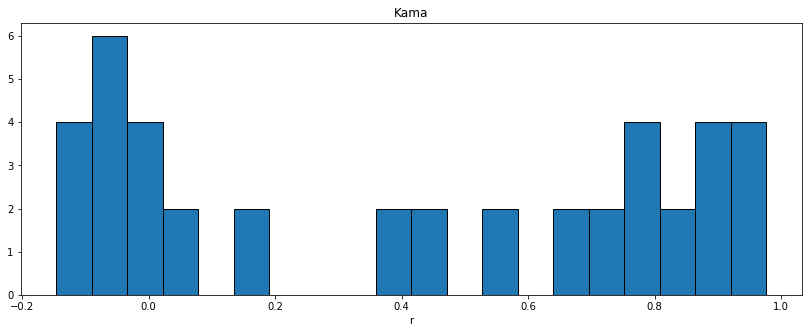

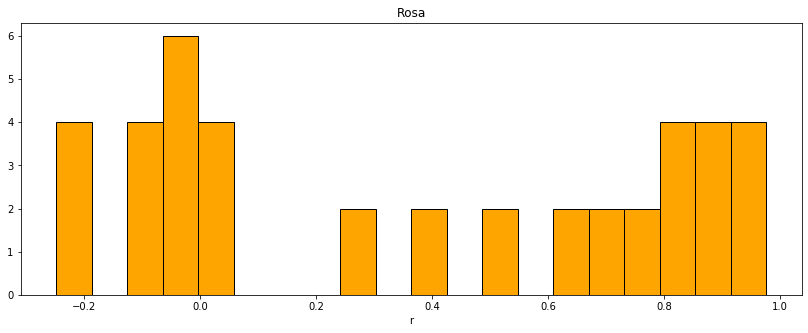

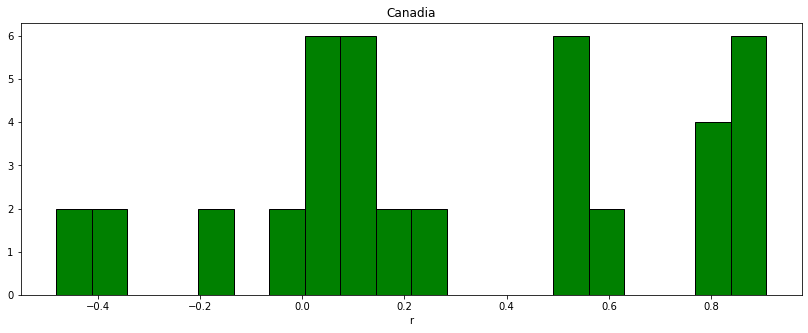

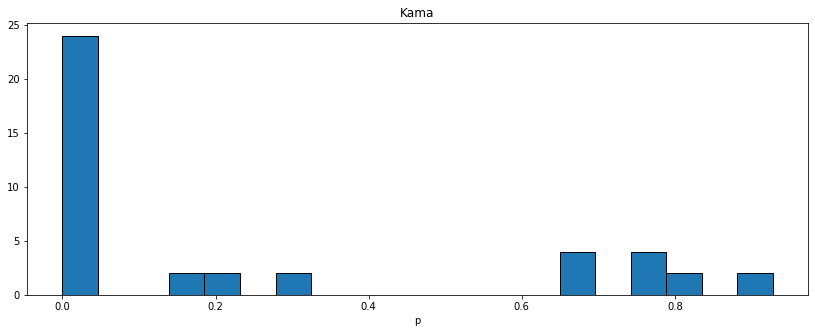

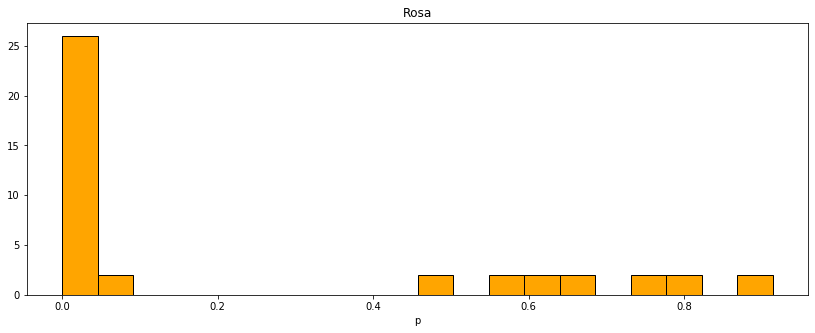

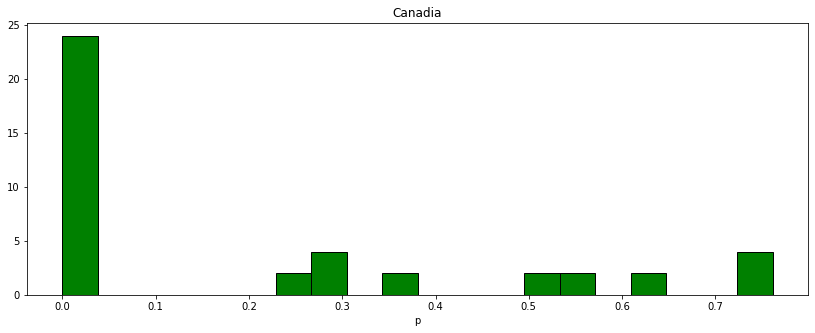

In [17]:
# Split seed classes for comparison:
pearsonDF1 = pearsonr(seeds1)
pearsonDF2 = pearsonr(seeds2)
pearsonDF3 = pearsonr(seeds3)

# Create plots to show the distributions of r and p scores:
_=pearsonDF1.drop('p', axis=1).hist(bins=20, figsize=(14,5), grid=False, edgecolor='k')
_=plt.title('Kama')
_=plt.xlabel('r')
_=pearsonDF2.drop('p', axis=1).hist(bins=20, figsize=(14,5), grid=False, edgecolor='k', color='orange')
_=plt.title('Rosa')
_=plt.xlabel('r')
_=pearsonDF3.drop('p', axis=1).hist(bins=20, figsize=(14,5), grid=False, edgecolor='k', color='green')
_=plt.title('Canadia')
_=plt.xlabel('r')
plt.show()

_=pearsonDF1.drop('r', axis=1).hist(bins=20, figsize=(14,5), grid=False, edgecolor='k')
_=plt.title('Kama')
_=plt.xlabel('p')
_=pearsonDF2.drop('r', axis=1).hist(bins=20, figsize=(14,5), grid=False, edgecolor='k', color='orange')
_=plt.title('Rosa')
_=plt.xlabel('p')
_=pearsonDF3.drop('r', axis=1).hist(bins=20, figsize=(14,5), grid=False, edgecolor='k', color='green')
_=plt.title('Canadia')
_=plt.xlabel('p')
plt.show()

The histograms above show noticeable spikes near zero for the p-values in each class. This means there are likely many statistically significant feature pairs that can be used for training the algorithm.


In [9]:
# Create a dataframe to hold all of the data from each class:
merged = pearsonDF1.merge(pearsonDF2, on=pearsonDF1.index)
merged.index=merged['key_0']
merged.drop('key_0', axis=1, inplace=True)
merged = merged.merge(pearsonDF3, on=merged.index)
merged.index=merged['key_0']
merged.drop('key_0', axis=1, inplace=True)
merged.drop_duplicates(inplace=True)
merged.columns = ['r Kama', 'p Kama', 'r Rosa', 'p Rosa', 'r Canadia','p Canadia']
merged.index.name = 'features'
merged.head()

,r Kama,p Kama,r Rosa,p Rosa,r Canadia,p Canadia
features,,,,,,
"(area, perimeter)",0.976437,5.131220e-47,0.975806,1.246915e-46,0.907601,2.478192e-27
"(area, compactness)",0.371037,1.566252e-03,0.272633,2.240792e-02,0.546760,9.734266e-07
"(area, length)",0.834778,2.728968e-19,0.826427,1.261563e-18,0.516603,4.690915e-06
"(area, width)",0.900066,3.138595e-26,0.880493,9.866088e-24,0.863824,6.290935e-22
"(area, asymmetry_coefficient)",-0.050482,6.781258e-01,-0.039503,7.454211e-01,0.039612,7.447464e-01


### Composite Heat Map

The comparison of features within each seed class produces a heatmap of both $ r $ and $ p $ values for each class. This leads to a total of six heat maps, two for each class. Instead of showing each heat map individually, a composite can be constructed.

The two dimensional array that constitutes the heat map of correlation coefficients or p-values for any one class can be expressed as a $ (21,1) $ dimensional vector. By labeling the rows with the features being compared, and the column with the class name, the data is reduced to a column vector. Each entry is the respective value of $r$ or $p$ for the features being compared within that class.

Doing this for all six comparisons and then combining the column vectors into a 2-D array yields the heat map below.

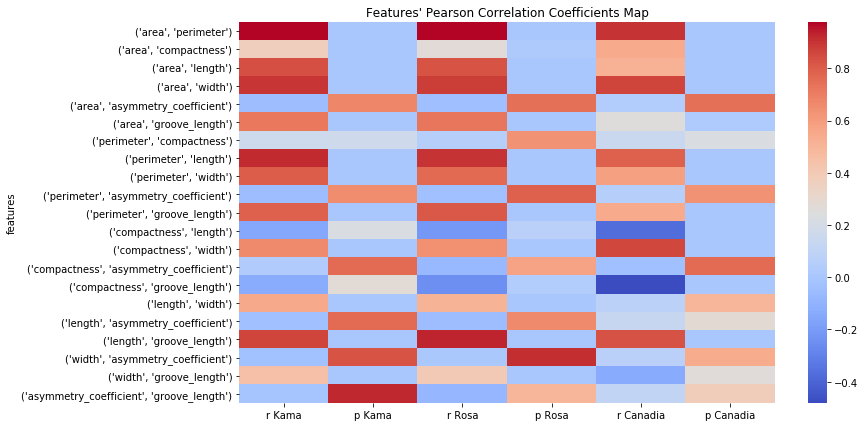

In [23]:
# Create a composite heatmap of all of the comparisons for each class:
_=plt.figure(figsize=(12,7))
_=sns.heatmap(merged, cmap='coolwarm')
_=plt.title('Features\' Pearson Correlation Coefficients Map')

Now we can use this data to find which pairings of columns are statistically significant. A large value of Pearson's Correlation Coefficient indicates a highly linear relationship between the features. This is not desirable when training a neural network; the fixed relationship offers no new information. Thus, we can shrewdly eliminate certain pairs of columns that are highly correlated. This will save in computation cost, as well as reduce the variance in the model.

The p-values can be used to determine the statistical significance of the calculated correlation coefficients. The statistically insignificant pairings can be later removed from the model to improve performance. 

To begin, a threshold of alpha=.5 is chosen; those pairs with a p-value below alpha will be deemed satistically significant. Ideally, the algorithm will be tested with varying values of alpha for optimization. The same should be done with the features that show up as statistically significant for some pairings but not for others. This overlap of significance makes in unclear which feature should be removed. To make the determination, a trial run should be performed with each possibility. The iteration with the best performance indicates the proper choice.  

In [11]:
#We can build a dataframe with fancy indexing to select the columns that are not statistically significant:
alpha = .5
pDF = merged.drop(['r Kama','r Rosa','r Canadia'], axis=1)

In [18]:
# Separate the significant from non-significant values:
sigDF = pd.DataFrame()
non_sigDF = pd.DataFrame()
for col in pDF.columns:
    tempDF = pDF.loc[:, str(col)]
    sigDF = pd.concat([sigDF, tempDF[tempDF.values < alpha]], axis=1)
    non_sigDF = pd.concat([non_sigDF, tempDF[tempDF.values >= alpha]], axis=1)

In [19]:
print('\nThe non-significant column pairs and their p-values are:\n')
non_sigDF


The non-significant column pairs and their p-values are:



p Kama    p Rosa  p Canadia
area                  asymmetry_coefficient  0.678126  0.745421   0.744746
asymmetry_coefficient groove_length          0.927880  0.501980        NaN
compactness           asymmetry_coefficient  0.761321  0.572663   0.761474
length                asymmetry_coefficient  0.763008  0.665560        NaN
perimeter             asymmetry_coefficient  0.657403  0.792066   0.638770
                      compactness                 NaN  0.637747        NaN
width                 asymmetry_coefficient  0.826516  0.914290   0.541480

Asymmetry coefficient shows up in $5$ out of $7$ of the comparisons deemed insignificant. This is a strong indication that this feature can be removed from the model for training purposes.

In [20]:
print('The significant column pairs and their p-values are:\n')
sigDF

The significant column pairs and their p-values are:



p Kama        p Rosa  \
area                  compactness            1.566252e-03  2.240792e-02   
                      groove_length          1.948985e-12  9.095355e-13   
                      length                 2.728968e-19  1.261563e-18   
                      perimeter              5.131220e-47  1.246915e-46   
                      width                  3.138595e-26  9.866088e-24   
asymmetry_coefficient groove_length                   NaN           NaN   
compactness           groove_length          2.794339e-01  3.775832e-02   
                      length                 2.268389e-01  7.123633e-02   
                      width                  2.998077e-10  1.844002e-09   
length                asymmetry_coefficient           NaN           NaN   
                      groove_length          3.637111e-22  1.439356e-32   
                      width                  7.896725e-07  5.581067e-06   
perimeter             compactness            1.724538e-01           NaN   
                      groove_length          2.527750e-16  1.536789e-17   
                      length                 1.385434e-29  3.659813e-27   
                      width                  6.834998e-17  8.802066e-15   
width                 groove_length          1.043182e-04  5.685671e-04   

                                                p Canadia  
area                  compactness            9.734266e-07  
                      groove_length          3.079657e-02  
                      length                 4.690915e-06  
                      perimeter              2.478192e-27  
                      width                  6.290935e-22  
asymmetry_coefficient groove_length          3.746917e-01  
compactness           groove_length          2.488773e-05  
                      length                 1.618166e-03  
                      width                  1.121541e-21  
length                asymmetry_coefficient  2.845390e-01  
                      groove_length          8.598827e-19  
                      width                  4.994547e-01  
perimeter             compactness            2.298824e-01  
                      groove_length          1.058869e-06  
                      length                 2.499285e-16  
                      width                  8.990530e-08  
width                 groove_length          2.665358e-01

In [24]:
non_sigDF.min()
print('The minimum of the non-significant values:')

The minimum of the non-significant values:


In [25]:
sigDF.max()
print('The maximum of the significant values:')

The maximum of the significant values:


## Conclusion
We have seen via bootstrapping that the differences in seed measurement are not flukes of random chance from the collected samples. The Pearson R and P values determined which feature pairs are statistically significant by choosing a threshold of 0.5. We can now make more informed decisions about how to proceed in constructing a neural network to identify each seed class.